In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df_original = yf.download("META", start="2021-01-01", end="2025-07-01", auto_adjust = True)
df_original 

[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2021-01-04,267.472626,273.499559,263.753041,273.280758,15106100
2021-01-05,269.491547,270.913737,266.746596,266.826176,9871600
2021-01-06,261.873352,266.289129,258.591369,260.570502,24354100
2021-01-07,267.273712,270.128048,263.335327,264.449211,15789800
2021-01-08,266.110138,267.482613,261.744075,266.846091,18528300
...,...,...,...,...,...
2025-06-24,712.200012,713.190002,702.109985,704.890015,13823200
2025-06-25,708.679993,716.580017,705.380005,713.320007,9320400


In [3]:
df_original.columns = df_original.columns.get_level_values(0)
df_original.reset_index(inplace=True)
df_original.columns = df_original.columns.str.lower()
df_original['date'] = pd.to_datetime(df_original['date'])
df_original.set_index('date', inplace=True)

if 'index' in df_original.columns:
    df_original.drop(columns='index', inplace=True)
    
df_original

Price,close,high,low,open,volume
date,,,,,
2021-01-04,267.472626,273.499559,263.753041,273.280758,15106100
2021-01-05,269.491547,270.913737,266.746596,266.826176,9871600
2021-01-06,261.873352,266.289129,258.591369,260.570502,24354100
2021-01-07,267.273712,270.128048,263.335327,264.449211,15789800
2021-01-08,266.110138,267.482613,261.744075,266.846091,18528300
...,...,...,...,...,...
2025-06-24,712.200012,713.190002,702.109985,704.890015,13823200
2025-06-25,708.679993,716.580017,705.380005,713.320007,9320400
2025-06-26,726.090027,728.219971,711.049988,714.359985,13964800


In [ ]:
def run_backtest(df, short_window, long_window, sl, tp):
    if short_window >= long_window:
        return -np.inf 

    # Extraire seulement la colonne "close" pour éviter la copie du dataframe complet
    close_prices = df["close"].values
    N = len(close_prices)
    
    # Calculer les EMAs directement sur les prix de clôture
    ema_short = pd.Series(close_prices).ewm(span=short_window, adjust=False).mean().values
    ema_long = pd.Series(close_prices).ewm(span=long_window, adjust=False).mean().values
    
    # Générer les signaux
    signals = np.where(ema_short > ema_long, 1, 0)
    positions = np.diff(signals, prepend=0)
    
    capital_inicial = 100.0
    equity = [capital_inicial]
    pos = 0 
    entry_price = 0

    for i in range(1, N):
        equity_today = equity[i-1] 
        
        if pos == 1: 
            if close_prices[i] >= entry_price * (1 + tp):
                equity_today *= (1 + tp)
                pos = 0
            elif close_prices[i] <= entry_price * (1 - sl):
                equity_today *= (1 - sl)
                pos = 0
        
        if pos == 0:
            if positions[i] == 1: 
                pos = 1
                entry_price = close_prices[i]

        equity.append(equity_today)
    
    if len(set(equity)) == 1:  # Tous les éléments sont identiques
        return 0

    equity_series = pd.Series(equity)
    ret = np.log(equity_series).diff().mean() * 252
    
    vol = np.log(equity_series).diff().std() * np.sqrt(252)
    
    if vol == 0 or np.isnan(vol):
        return 0
        
    rf = 0.01 
    sharpe_ratio = (ret - rf) / vol
    
    return sharpe_ratio    def run_backtest(df, short_window, long_window, sl, tp):
        if short_window >= long_window:
            return -np.inf 
    
        # Extraire seulement la colonne "close" pour éviter la copie du dataframe complet
        close_prices = df["close"].values
        N = len(close_prices)
        
        # Calculer les EMAs directement sur les prix de clôture
        ema_short = pd.Series(close_prices).ewm(span=short_window, adjust=False).mean().values
        ema_long = pd.Series(close_prices).ewm(span=long_window, adjust=False).mean().values
        
        # Générer les signaux
        signals = np.where(ema_short > ema_long, 1, 0)
        positions = np.diff(signals, prepend=0)
        
        capital_inicial = 100.0
        equity = [capital_inicial]
        pos = 0 
        entry_price = 0
    
        for i in range(1, N):
            equity_today = equity[i-1] 
            
            if pos == 1: 
                if close_prices[i] >= entry_price * (1 + tp):
                    equity_today *= (1 + tp)
                    pos = 0
                elif close_prices[i] <= entry_price * (1 - sl):
                    equity_today *= (1 - sl)
                    pos = 0
            
            if pos == 0:
                if positions[i] == 1: 
                    pos = 1
                    entry_price = close_prices[i]
    
            equity.append(equity_today)
        
        if len(set(equity)) == 1:  # Tous les éléments sont identiques
            return 0
    
        equity_series = pd.Series(equity)
        ret = np.log(equity_series).diff().mean() * 252
        
        vol = np.log(equity_series).diff().std() * np.sqrt(252)
        
        if vol == 0 or np.isnan(vol):
            return 0
            
        rf = 0.01 
        sharpe_ratio = (ret - rf) / vol
        
        return sharpe_ratio

In [5]:
ema_short_range = range(1, 50, 1)
ema_long_range = range(2, 80, 2)
sl_range = np.arange(0.01, 0.15, 0.01)   
tp_range = np.arange(0.01, 0.20, 0.01)   

In [6]:
best_sharpe = float("-inf")
best_params = {}

In [7]:
total_combinations = len(ema_short_range) * len(ema_long_range) * len(sl_range) * len(tp_range)
progress_bar = tqdm(total=total_combinations, desc="Optimizando Parámetros")

for short_ema in ema_short_range:
    for long_ema in ema_long_range:
        for sl in sl_range:
            for tp in tp_range:
                sharpe = run_backtest(df_original, short_ema, long_ema, sl, tp)
                
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = {
                        'ema_corta': short_ema,
                        'ema_larga': long_ema,
                        'stop_loss': sl,
                        'take_profit': tp
                    }
                
                progress_bar.update(1)

progress_bar.close()

Optimizando Parámetros: 100%|██████████| 508326/508326 [07:20<00:00, 1154.09it/s]


In [12]:
print("\n--- ¡Optimización Completa! ---")
print(f"Mejor Sharpe Ratio encontrado: {best_sharpe:.4f}")
print("Mejores Parámetros:")
print(f"  - EMA Corta: {best_params['ema_corta']}")
print(f"  - EMA Larga: {best_params['ema_larga']}")
print(f"  - Stop Loss: {best_params['stop_loss']:.2%}")
print(f"  - Take Profit: {best_params['take_profit']:.2%}")


--- ¡Optimización Completa! ---
Mejor Sharpe Ratio encontrado: 2.0148
Mejores Parámetros:
  - EMA Corta: 1
  - EMA Larga: 2
  - Stop Loss: 1.00%
  - Take Profit: 6.00%


In [13]:
params = best_params

df_final = df_original.copy()
df_final["EMA_short"] = df_final["close"].ewm(span=params['ema_corta'], adjust=False).mean()
df_final["EMA_long"] = df_final["close"].ewm(span=params['ema_larga'], adjust=False).mean()

df_final['signal'] = 0
df_final['signal'] = np.where(df_final['EMA_short'] > df_final['EMA_long'], 1, 0)
df_final['position'] = df_final['signal'].diff()

df_final["Buy"] = np.where(df_final["position"] == 1, df_final["close"], np.nan)
df_final["Sell"] = np.where(df_final["position"] == -1, df_final["close"], np.nan)

In [14]:
equity = [100]
pos = 0
price = 0
N = len(df_final)
SL = params['stop_loss']
TP = params['take_profit']

for i in range(1, N): 
    equity.append(equity[i-1])
    
    if pos == 1: 
        if df_final["close"].iloc[i] >= price*(1+TP):
            pos = 0
            equity[i] *= (1+TP)
        elif df_final["close"].iloc[i] <= price*(1-SL):
            pos = 0
            equity[i] *= (1-SL)
            
    if pos == 0 and df_final["position"].iloc[i] == 1:
        pos = 1
        price = df_final["close"].iloc[i]

df_final["equity"] = equity

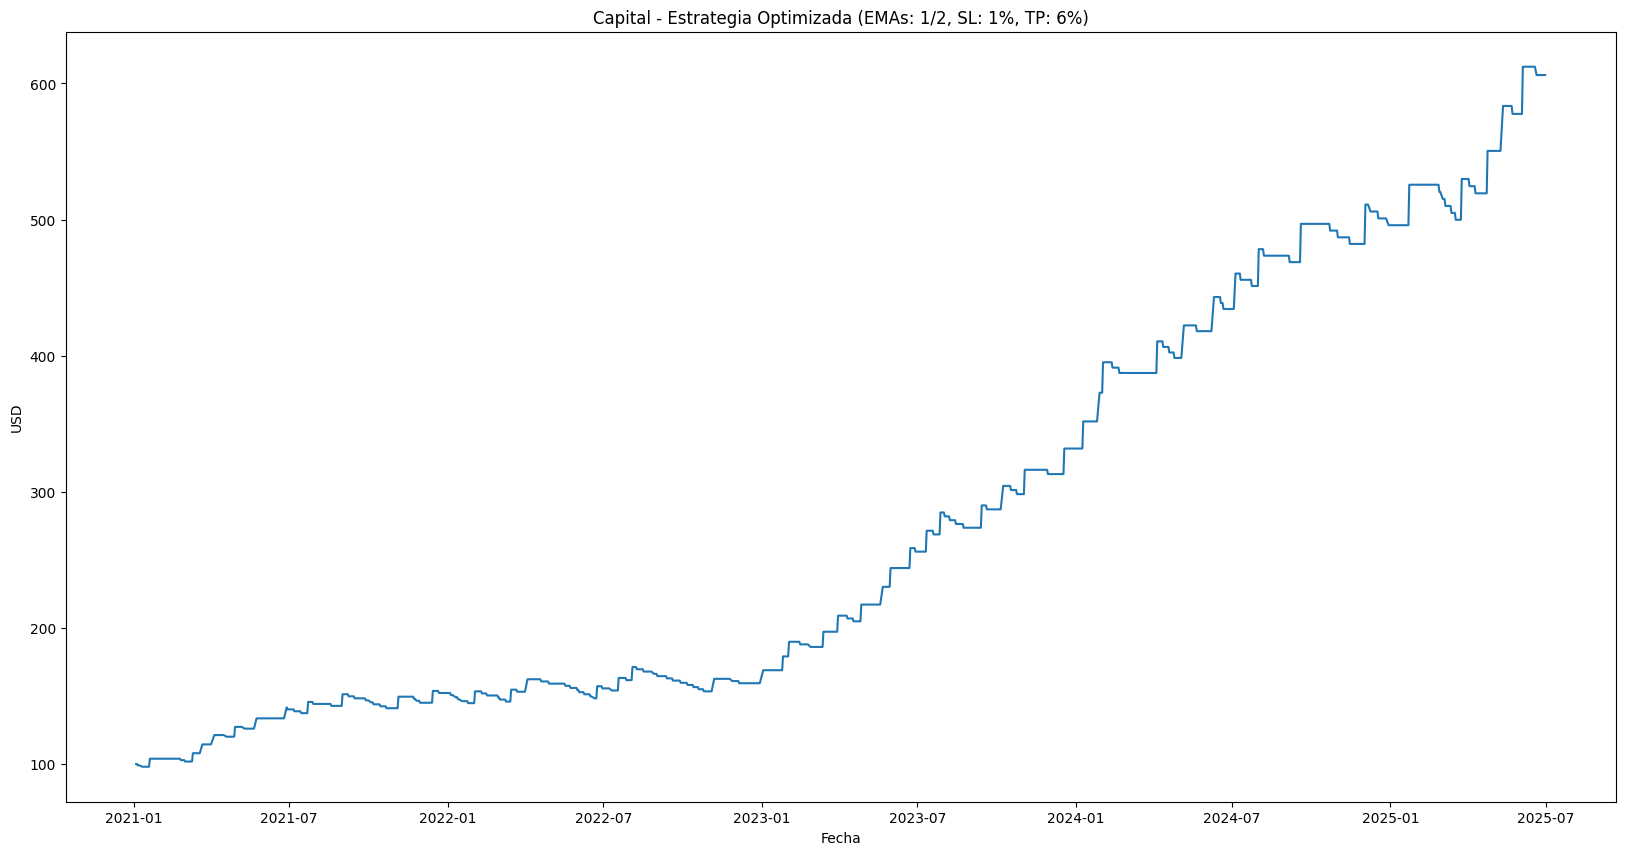

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df_final["equity"])
plt.title(f"Capital - Estrategia Optimizada (EMAs: {params['ema_corta']}/{params['ema_larga']}, SL: {SL:.0%}, TP: {TP:.0%})")
plt.xlabel("Fecha")
plt.ylabel("USD")
plt.show()

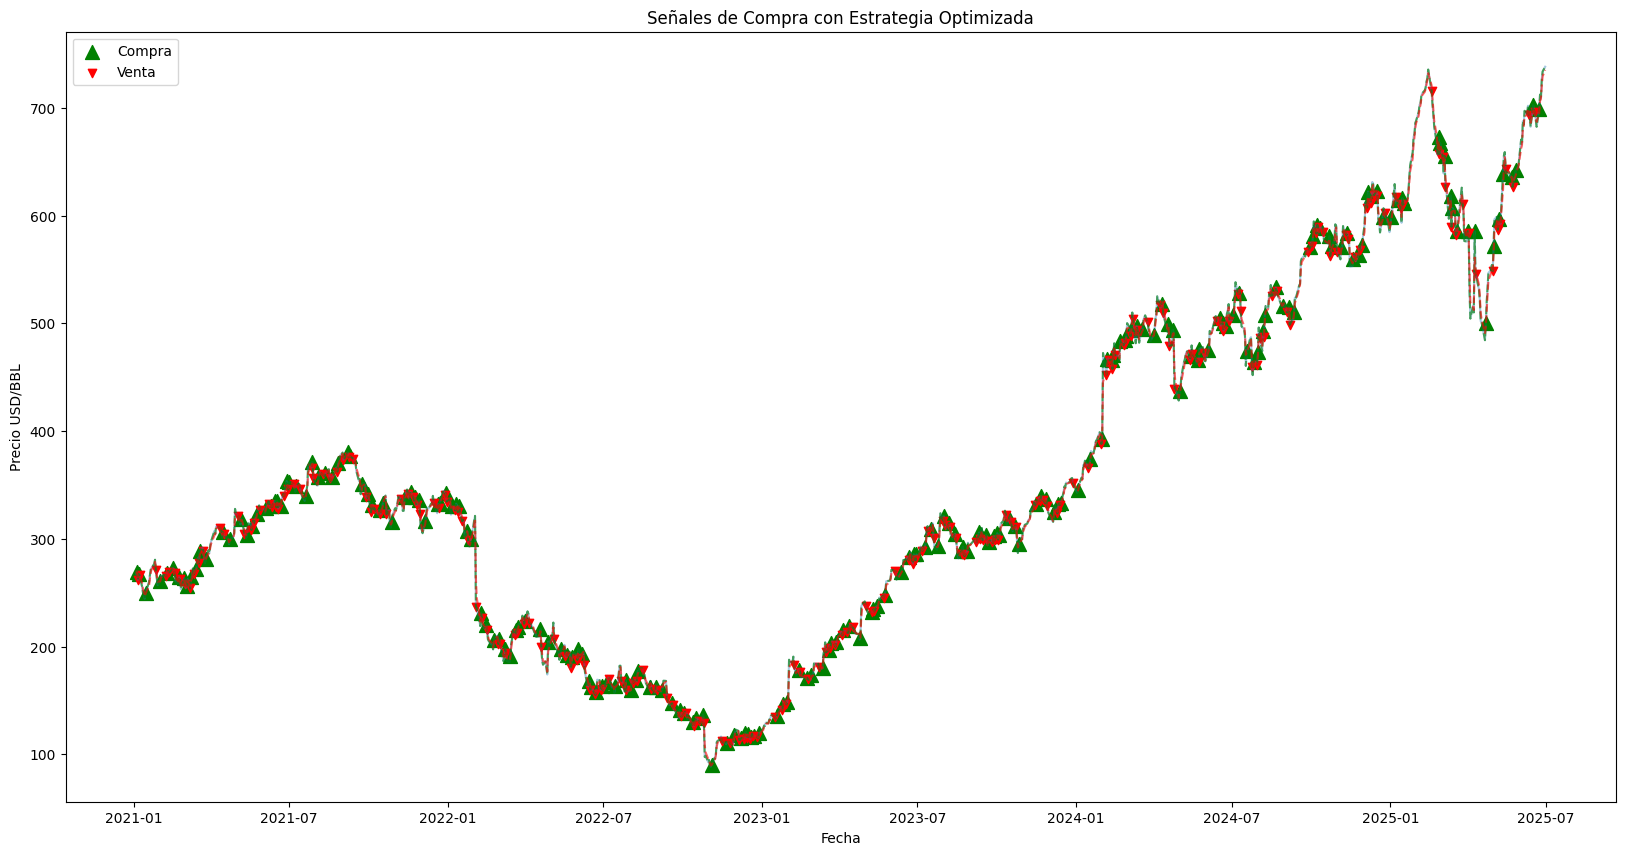

In [16]:
plt.figure(figsize=(20,10))
plt.plot(df_final["close"], alpha = 0.4)
plt.plot(df_final["EMA_short"], color = "green", alpha = 0.6, linestyle='--')
plt.plot(df_final["EMA_long"], color = "red", alpha = 0.6, linestyle='--')
plt.scatter(df_final.index, df_final["Buy"], color = "green", marker = "^", s=100, label = "Compra")
plt.scatter(df_final.index, df_final["Sell"], color = "red", marker = "v", label = "Venta")
plt.title("Señales de Compra con Estrategia Optimizada")
plt.xlabel("Fecha")
plt.ylabel("Precio USD/BBL")
plt.legend(loc = "upper left")
plt.show()